Работу выполнил Данил Исламов (Danil_Islamoff_274397404)

При выполнении задания я использовал свои картинки стилей и контента, соответственно, заданные в ноутбуке веса были подобраны под них. В целом же, веса стоит калибровать (функции тренировки позволяют это сделать) для каждого отдельного случая

### Classic NST

Реализация модели взята из семинарского [ноутбука](https://drive.google.com/open?id=1lrfcInS--qOdJlCNbpnJzghWngPGTeZz) к занятию по GAN и Style Transfer и дополнена некоторыми элементами с сайта PyTorch (https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)

In [ ]:
%matplotlib inline
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
!ls images/

abstract-art.jpg   Jackson-Pollock-detail.jpg  picasso.jpg	  unnamed.jpg
colored_cat.jpg    lisa.jpg		       rectangles.jpg	  Yoda.jpg
dancing.jpg	   mask2.jpg		       some_cool_guy.jpg
geometric_art.jpg  mask.jpg		       The_Scream.jpg


Загрузка изображений

In [ ]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("images/colored_cat.jpg")
content_img = image_loader("images/Yoda.jpg")

assert style_img.size() == content_img.size()

Выведем то, что было загружено

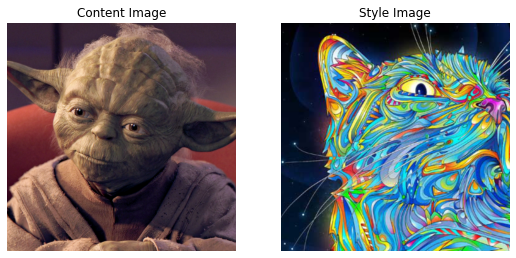

In [ ]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.axis('off')
    plt.imshow(image)
    if title is not None:
        plt.title(title)

# отрисовка
plt.figure(figsize=(9 ,6))

plt.subplot(1, 2, 1)
imshow(content_img, title='Content Image')

plt.subplot(1, 2, 2)
imshow(style_img, title='Style Image')

Определим Content loss

In [ ]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Определим Style loss

In [ ]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [ ]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим иcпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Определим после каких уровней мы будем считать ошибки стиля, а после каких — ошибки контента

In [ ]:
content_layers_default = ['conv_4', 'conv_5']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Определим предобученную модель

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to the list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                # Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        # выбрасываем все уровни после последенего style loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        # добaвляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Обучение модели

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                # взвешивание ошибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 47.228718 Content Loss: 273.523804

run [100]:
Style Loss : 24.701347 Content Loss: 219.906860

run [150]:
Style Loss : 20.439535 Content Loss: 201.713531

run [200]:
Style Loss : 19.115919 Content Loss: 194.223755

run [250]:
Style Loss : 19.451490 Content Loss: 190.001190

run [300]:
Style Loss : 18.368872 Content Loss: 189.558640

run [350]:
Style Loss : 18.845396 Content Loss: 190.327515

run [400]:
Style Loss : 31.668280 Content Loss: 208.374664

run [450]:
Style Loss : 21.045933 Content Loss: 194.211716

run [500]:
Style Loss : 26.177099 Content Loss: 212.808350



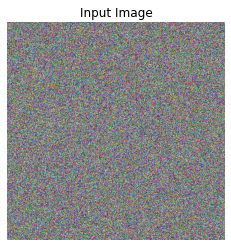

In [ ]:
# if you want to use the copy of content image as the input, uncomment the line below:
# input_img = content_img.clone()
# if you want to use white noise instead, uncomment the following:
input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=50000, content_weight=2)

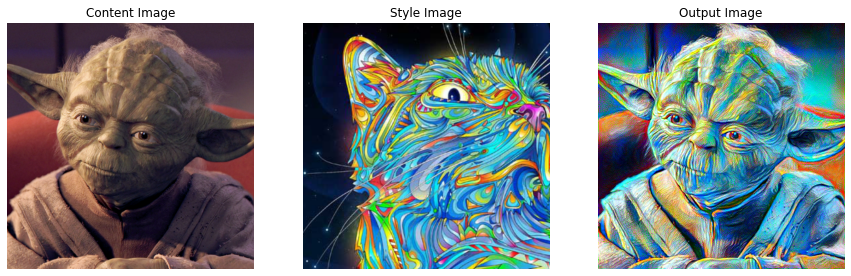

In [ ]:
plt.figure(figsize=(15, 11))

plt.subplot(1, 3, 1)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 2)
imshow(style_img, title='Style Image')

plt.subplot(1, 3, 3)
imshow(output, title='Output Image')
# Uncomment the below to save the output
# plt.imsave(output, 'output.png')
plt.ioff()
plt.show()

### Local style trasfer

Подкорректируем архитектуру так, чтобы перенос стиля выполнялся только на часть картинки — для этого используем маску

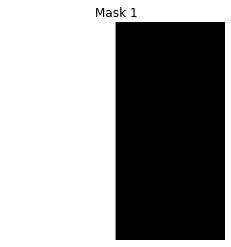

In [ ]:
mask1 = (image_loader("images/mask2.jpg") >= 0.5).float()
# Сразу зададим зеркальную маску — пригодится для следующего пункта
mask2 = (mask1 == 0).float()
imshow(mask1, title='Mask 1')

Меняем алгоритм вычисления матрицы Грама и Style лосса так, чтобы учитывались только признаки на выделенной маской части картинки

In [ ]:
def part_gram_matrix(input, mask):
        input = input * torch.cat([mask] * input.size()[1], dim=1)
        batch_size , h, w, f_map_num = input.size()
        
        features = input.view(batch_size * h, w * f_map_num)

        G = torch.mm(features, features.t())

        return G.div(batch_size * h * w * f_map_num)

In [ ]:
class PartStyleLoss(nn.Module):
        def __init__(self, target_feature, mask=None):
            super(PartStyleLoss, self).__init__()
            self.mask = transforms.Compose([
                                            transforms.Resize(target_feature.size()[2]),
                                            transforms.Grayscale()])(mask)
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            self.mask = transforms.Resize(input.size()[2])(self.mask)
            G = part_gram_matrix(input, self.mask)
            self.loss = F.mse_loss(G, self.target)
            return input

Корректируем обучение с учетом нового лосса

In [ ]:
def get_part_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img, mask,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        normalization = Normalization(normalization_mean, normalization_std).to(device)

        content_losses = []
        style_losses = []

        model = nn.Sequential(normalization)

        i = 0
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = PartStyleLoss(target_feature, mask)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], PartStyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def run_part_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, mask, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_part_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img, mask)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():

                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                # взвешивание ошибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 69.182610 Content Loss: 389.640778

run [100]:
Style Loss : 33.508694 Content Loss: 307.202911

run [150]:
Style Loss : 26.046595 Content Loss: 277.783081

run [200]:
Style Loss : 31.058973 Content Loss: 260.014221

run [250]:
Style Loss : 76.803719 Content Loss: 241.905212

run [300]:
Style Loss : 25.604242 Content Loss: 256.959045

run [350]:
Style Loss : 222.155319 Content Loss: 302.037323

run [400]:
Style Loss : 24.894575 Content Loss: 261.235016

run [450]:
Style Loss : 22.129961 Content Loss: 254.575485

run [500]:
Style Loss : 27.863174 Content Loss: 260.328918



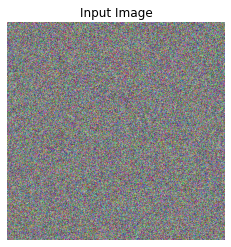

In [ ]:
# if you want to use the copy of content image as the input, uncomment the line below:
# input_img = content_img.clone()
# if you want to use white noise instead, uncomment the following:
input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_part_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, mask1, input_img, content_weight=2)

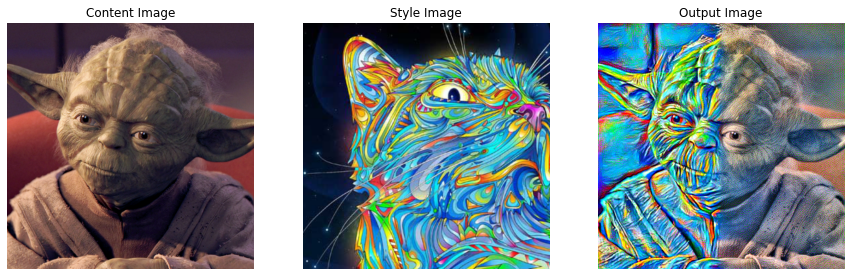

In [ ]:
plt.figure(figsize=(15, 11))

plt.subplot(1, 3, 1)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 2)
imshow(style_img, title='Style Image')

plt.subplot(1, 3, 3)
imshow(output, title='Output Image')
# Uncomment the below to save the output
# plt.imsave(output, 'output.png')
plt.ioff()
plt.show()

### Local two-style transfer

Теперь будем одновременно переносить разные стили на выделенные соответствующими масками части картинки. Для этого добавим дополнительные слои для подсчёта лосса второго стиля. Реализация лосса останется такой же, как и в предыдущем пункте.

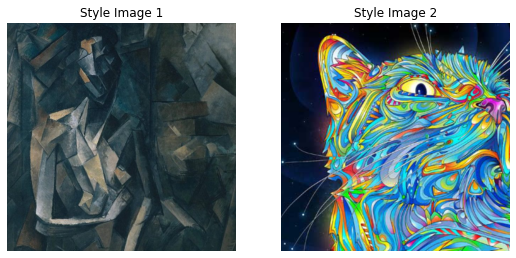

In [ ]:
style_img1 = image_loader("images/picasso.jpg")
style_img2 = image_loader("images/colored_cat.jpg")

plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
imshow(style_img1, title='Style Image 1')

plt.subplot(1, 2, 2)
imshow(style_img2, title='Style Image 2')

In [ ]:
def get_2style_local_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img1, style_img2, content_img, mask1, mask2,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        normalization = Normalization(normalization_mean, normalization_std).to(device)

        content_losses = []
        style_losses1 = []
        style_losses2 = []

        model = nn.Sequential(normalization)

        i = 0
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style_img1).detach()
                style_loss1 = PartStyleLoss(target_feature1, mask1)
                model.add_module("style_1_loss_{}".format(i), style_loss1)
                style_losses1.append(style_loss1)
                
                target_feature2 = model(style_img2).detach()
                style_loss2 = PartStyleLoss(target_feature2, mask2)
                model.add_module("style_2_loss_{}".format(i), style_loss2)
                style_losses2.append(style_loss2)

        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], PartStyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses1, style_losses2, content_losses

In [ ]:
def run_2style_local_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img1, style_img2, mask1, mask2, input_img, num_steps=500,
                        style_weight1=100000, style_weight2=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses1, style_losses2, content_losses = get_2style_local_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img1, style_img2, content_img, mask1, mask2)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score1 = 0
                style_score2 = 0
                content_score = 0

                for sl in style_losses1:
                    style_score1 += sl.loss
                for sl in style_losses2:
                    style_score2 += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                # взвешивание ошибки
                style_score1 *= style_weight1
                style_score2 *= style_weight2
                style_score = style_score1 + style_score2
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 202.502350 Content Loss: 392.015778

run [100]:
Style Loss : 77.667465 Content Loss: 338.346558

run [150]:
Style Loss : 59.069263 Content Loss: 310.513855

run [200]:
Style Loss : 51.951530 Content Loss: 294.005005

run [250]:
Style Loss : 47.526253 Content Loss: 286.415222

run [300]:
Style Loss : 48.456238 Content Loss: 279.844452

run [350]:
Style Loss : 51.379257 Content Loss: 275.939575

run [400]:
Style Loss : 89.306755 Content Loss: 281.484955

run [450]:
Style Loss : 50.981960 Content Loss: 278.721619

run [500]:
Style Loss : 680.034241 Content Loss: 301.261230



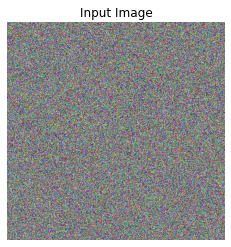

In [ ]:
# if you want to use the copy of content image as the input, uncomment the line below:
# input_img = content_img.clone()
# if you want to use white noise instead, uncomment the following:
input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_2style_local_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img1, style_img2, mask1, mask2, input_img,
                            style_weight1=1000000, content_weight=2)

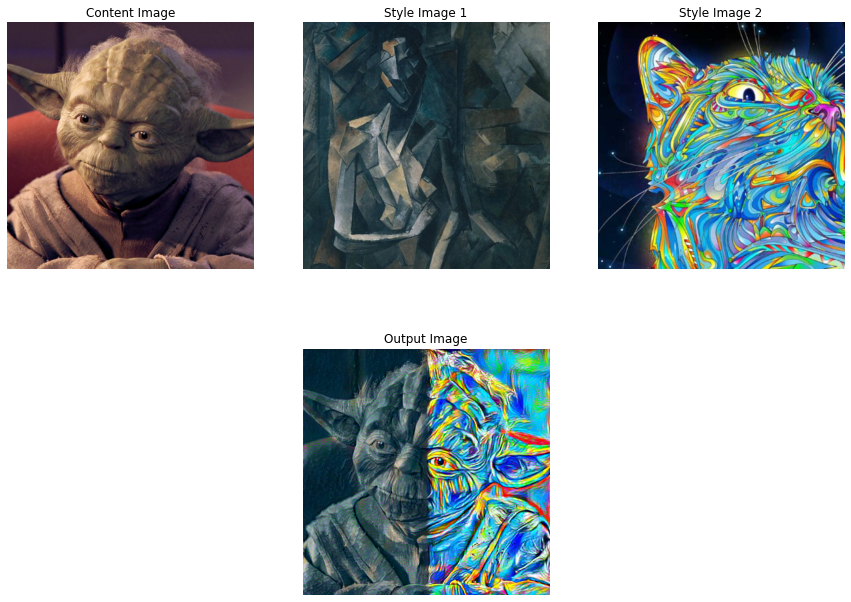

In [ ]:
plt.figure(figsize=(15, 11))

plt.subplot(2, 3, 1)
imshow(content_img, title='Content Image')

plt.subplot(2, 3, 2)
imshow(style_img1, title='Style Image 1')

plt.subplot(2, 3, 3)
imshow(style_img2, title='Style Image 2')

plt.subplot(2, 3, 5)
imshow(output, title='Output Image')
# Uncomment the below to save the output
# plt.imsave(output, 'output.png')
plt.ioff()
plt.show()

### Simultaneous two-style transfer

В этом пункте снова будем переносить два стиля, только теперь сделаем это без маски, на всю картинку. Аналогично предыдущему пункту, добавим в сеть слои, которые будут считать лосс для второго стиля

In [ ]:
def get_2style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img1, style_img2, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        normalization = Normalization(normalization_mean, normalization_std).to(device)

        content_losses = []
        style_losses1 = []
        style_losses2 = []

        model = nn.Sequential(normalization)

        i = 0
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style_img1).detach()
                style_loss1 = StyleLoss(target_feature1)
                model.add_module("style_1_loss_{}".format(i), style_loss1)
                style_losses1.append(style_loss1)
                
                target_feature2 = model(style_img2).detach()
                style_loss2 = StyleLoss(target_feature2)
                model.add_module("style_2_loss_{}".format(i), style_loss2)
                style_losses2.append(style_loss2)

        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses1, style_losses2, content_losses

Веса стилей здесь (как и в предыдущих пунктах) определяются параметрами style_weight

In [ ]:
def run_2style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img1, style_img2, input_img, num_steps=500,
                        style_weight1=100000, style_weight2=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses1, style_losses2, content_losses = get_2style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img1, style_img2, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score1 = 0
                style_score2 = 0
                content_score = 0

                for sl in style_losses1:
                    style_score1 += sl.loss
                for sl in style_losses2:
                    style_score2 += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                # взвешивание ошибки
                style_score1 *= style_weight1
                style_score2 *= style_weight2
                style_score = style_score1 + style_score2
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 1812.208374 Content Loss: 62.416164

run [100]:
Style Loss : 1798.489380 Content Loss: 40.279625

run [150]:
Style Loss : 1794.498047 Content Loss: 35.538975

run [200]:
Style Loss : 1793.241699 Content Loss: 33.879150

run [250]:
Style Loss : 1792.878418 Content Loss: 33.216366

run [300]:
Style Loss : 1792.687256 Content Loss: 32.900261

run [350]:
Style Loss : 1792.576538 Content Loss: 33.174995

run [400]:
Style Loss : 1793.288574 Content Loss: 33.923965

run [450]:
Style Loss : 1794.629150 Content Loss: 35.368370

run [500]:
Style Loss : 1793.177490 Content Loss: 33.269257



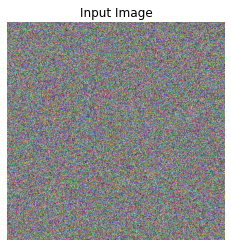

In [ ]:
# if you want to use the copy of content image as the input, uncomment the line below:
# input_img = content_img.clone()
# if you want to use white noise instead, uncomment the following:
input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_2style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img1, style_img2, input_img,
                            style_weight1=100000, style_weight2=30000, content_weight=2)

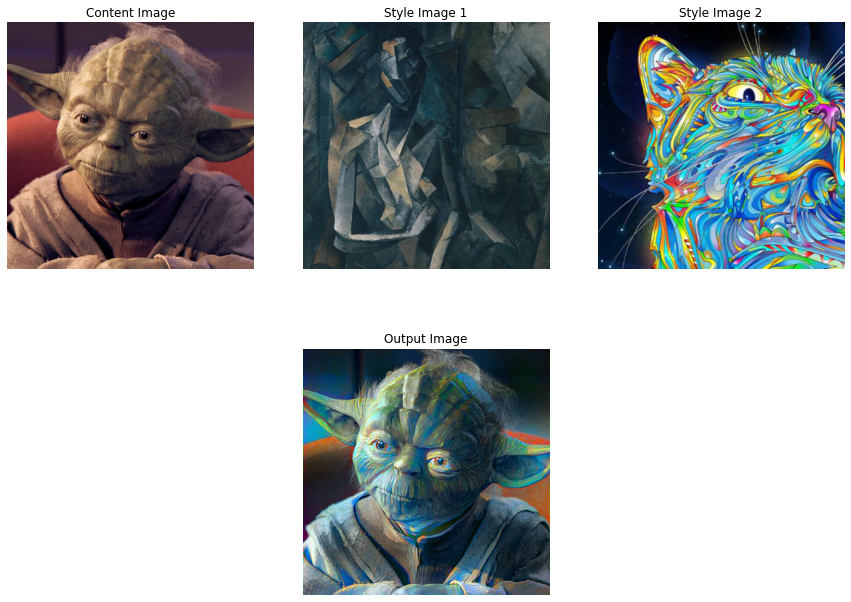

In [ ]:
plt.figure(figsize=(15, 11))

plt.subplot(2, 3, 1)
imshow(content_img, title='Content Image')

plt.subplot(2, 3, 2)
imshow(style_img1, title='Style Image 1')

plt.subplot(2, 3, 3)
imshow(style_img2, title='Style Image 2')

plt.subplot(2, 3, 5)
imshow(output, title='Output Image')
# Uncomment the below to save the output
# plt.imsave(output, 'output.png')
plt.ioff()
plt.show()

Все архитектуры были сделаны для переноса двух стилей, однако они достаточно легко адаптируются и под большее количество

